<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Predicting Loan Repayment</h1><br>

<p align="center">
<img src="images/Loans-borrow-repay.jpg"; style="height: 400px; width: 800px">
</p>

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Introduction</h2><br>
The two most critical questions in the lending industry are: 1) How risky is the borrower? 2) Given the borrower's risk, should we lend him/her? The answer to the first question determines the interest rate the borrower would have. Interest rate measures among other things (such as time value of money) the riskness of the borrower, i.e. the riskier the borrower, the higher the interest rate. With interest rate in mind, we can then determine if the borrower is eligible for the loan.

Investors (lenders) provide loans to borrowers in exchange for the promise of repayment with interest. That means the lender only makes profit (interest) if the borrower pays off the loan. However, if he/she doesn't repay the loan, then the lender loses money.

We'll be using publicly available data from [LendingClub.com](https://www.LendingClub.com). The data covers the 9,578 loans funded by the platform between May 2007 and February 2010. The interest rate is provided to us for each borrower. Therefore, so we'll address the second question indirectly by trying to predict if the borrower will repay the loan by its mature date or not. Through this excerise we'll illustrate three modeling concepts:
- What to do with missing values.
- Techniques used with imbalanced classification problems.
- Illustrate how to build an ensemble model using two methods: blending and stacking, which most likely gives us a boost in performance.

Below is a short description of each feature in the data set:
- **credit_policy**: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
- **purpose**: The purpose of the loan such as: credit_card, debt_consolidation, etc.
- **int_rate**: The interest rate of the loan (proportion).
- **installment**: The monthly installments (\$) owed by the borrower if the loan is funded.
- **log_annual_inc**: The natural log of the annual income of the borrower.
- **dti**: The debt-to-income ratio of the borrower.
- **fico**: The FICO credit score of the borrower.
- **days_with_cr_line**: The number of days the borrower has had a credit line.
- **revol_bal**: The borrower's revolving balance.
- **revol_util**: The borrower's revolving line utilization rate.
- **inq_last_6mths**: The borrower's number of inquiries by creditors in the last 6 months.
- **delinq_2yrs**: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
- **pub_rec**: The borrower's number of derogatory public records.
- **not_fully_paid**: indicates whether the loan was not paid back in full (the borrower either defaulted or the borrower was deemed unlikely to pay it back).

Let's load the data and check:
- Data types of each feature
- If we have missing values
- If we have imbalanced data

In [10]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute
from fancyimpute import IterativeImputer
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers

os.chdir("../")
from scripts.plot_roc import plot_roc_and_pr_curves
os.chdir("notebooks/")

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [11]:
# Load the data
df = pd.read_csv("../data/loans.csv")

# Check both the datatypes and if there is missing values
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each feature:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head()

Data types:
-----------
credit_policy          int64
purpose               object
int_rate             float64
installment          float64
log_annual_inc       float64
dti                  float64
fico                   int64
days_with_cr_line    float64
revol_bal              int64
revol_util           float64
inq_last_6mths       float64
delinq_2yrs          float64
pub_rec              float64
not_fully_paid         int64
dtype: object

Sum of null values in each feature:
-----------------------------------
credit_policy         0
purpose               0
int_rate              0
installment           0
log_annual_inc        4
dti                   0
fico                  0
days_with_cr_line    29
revol_bal             0
revol_util           62
inq_last_6mths       29
delinq_2yrs          29
pub_rec              29
not_fully_paid        0
dtype: int64


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0


Positive examples = 1533
Negative examples = 8045
Proportion of positive to negative examples = 19.06%


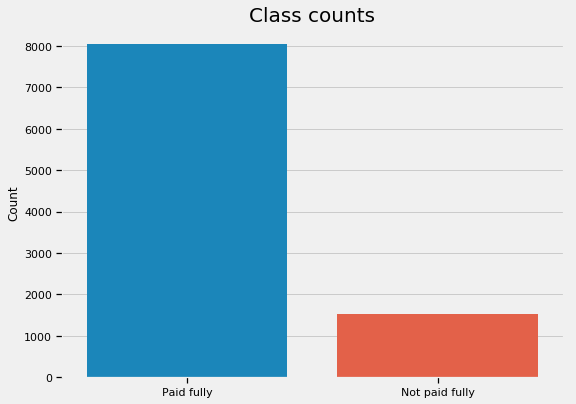

In [12]:
# Get number of positve and negative examples
pos = df[df["not_fully_paid"] == 1].shape[0]
neg = df[df["not_fully_paid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["not_fully_paid"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

It looks like we have only one categorical feature ("purpose"). Also, six features have missing values (no missing values in labels). Moreover, the data set is pretty imbalanced as expected where positive examples ("not paid fully") are only 19%. We'll explain in the next section how to handle all of them after giving an overview of ensemble methods.

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Modeling</h2><br>
**Ensemble methods** can be defined as combining several different models (base learners) into final model (meta learner) to reduce the generalization error. It relies on the assumption that each model would look at a different aspect of the data which yield to capturing part of the truth. Combining good performing models the were trained independently will capture more of the truth than a single model. Therefore, this would result in more accurate predictions and lower generalization errors.
- Almost always ensemble model performance gets improved as we add more models.
- Try to combine models that are as much different as possible. This will reduce the correlation between the models that will improve the performance of the ensemble model that will lead to significantly outperform the best model. In the worst case where all models are perfectly correlated, the ensemble would have the same performance as the best model and sometimes even lower if some models are very bad. As a result, pick models that are as good as possible.

Diﬀerent ensemble methods construct the ensemble of models in diﬀerent ways. Below are the most common methods:
- Blending: Averaging the predictions of all models.
- Bagging: Build different models on different datasets and then take the majority vote from all the models. Given the original dataset, we sample with replacement to get the same size of the original dataset. Therefore, each dataset will include, on average, 2/3 of the original data and the rest 1/3 will be duplicates. Since each model will be built on a different dataset, it can be seen as a different model. *Random Forest* improves on default bagging trees by reducing the likelihood of strong features to picked on every split. In other words, it reduces the number of features available at each split from $n$ features to, for example, $n/2$ or $log(n)$ features. This will reduce correlation --> reduce variance.
- Boosting: Build models sequentially. That means each model learns from the residuals of the previous model. The output will be all output of each single model weighted by the learning rate ($\lambda$). It reduces the bias resulted from bagging by learning sequentially from residuals of previous trees (models). 
- Stacking: Build k models called base learners. Then fit a model to the output of the base learners to predict the final output.

Since we'll be using Random Fores (bagging) and Gradient Boosting (boosting) classifiers as base learners in the ensemble model, we'll illustrate only averaging and stacking ensemble methods. Therefore, modeling parts would be consisted of three parts:
- Strategies to deal with missing values.
- Strategies to deal with imbalanced datasets.
- Build ensemble models.

Before going further, the following data preprocessing steps will be applicable to all models:
1. Create dummy variables from the feature "purpose" since its nominal (not ordinal) categorical variable. It's also a good practice to drop the first one to avoid linear dependency between the resulted features since some algorithms may struggle with this issue.
3. Split the data into training set (70%), and test set (30%). Training set will be used to fit the model, and test set will be to evaluate the best model to get an estimation of generalization error. Instead of having validation set to tune hyperparameters and evaluate different models, we'll use 10-folds cross validation because it's more reliable estimate of generalization error.
2. Standardize the data. We'll be using `RobustScaler` so that the standarization will be less influenced by the outliers, i.e. more robust. It centers the data around the median and scale it using *interquartile range (IQR)*. This step will be included in the pipelines for each model as a transformer so we will not do it separately.

In [13]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["purpose"], drop_first=True)
df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,0.0,0.0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,0.0,0.0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,0.0,0.0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,0.0,0.0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,1.0,0.0,0,1,0,0,0,0,0


 <h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Strategies to deal with missing value</h3><br>
Almost always real world data sets have missing values. This can be due, for example, users didn't fill some part of the forms or some transformations happened while collecting and cleaning the data before they send it to you. Sometimes missing values are informative and weren't generated randomly. Therefore, it's a good practice to add binary features to check if there is missing values in each row for each feature that has missing values. In our case, six features have missing values so we would add six binary features one for each feature. For example, "log_annual_inc" feature has missing values, so we would add a feature "is_log_annual_inc_missing" that takes the values $\in \{0, 1\}$. Good thing is that the missing values are in the predictors only and not the labels. Below are some of the most common strategies for dealing with missing values:
- Simply delete all examples that have any missing values. This is usually done if the missing values are very small compared to the size of the data set and the missing values were random. In other words, the added binary features did not improve the model. One disadvantage for this strategy is that the model will throw an error when test data has missing values at prediction.
- Impute the missing values using the mean of each feature separately.
- Impute the missing values using the median of each feature separately.
- Use *Multivariate Imputation by Chained Equations (MICE)*. The main disadvantage of MICE is that we can't use it as a transformer in sklearn pipelines and it requires to use the full data set when imputing the missing values. This means that there will be a risk of data leakage since we're using both training and test sets to impute the missing values. The following steps explain how MICE works:
    - First step: Impute the missing values using the mean of each feature separately.
    - Second step: For each feature that has missing values, we take all other features as predictors (including the ones that had missing values) and try to predict the values for this feature using linear regression for example. The predicted values will replace the old values for that feature. We do this for all features that have missing values, i.e. each feature will be used once as a target variable to predict its values and the rest of the time as a predictor to predict other features' values. Therefore, one complete cycle (iteration) will be done once we run the model $k$ times to predict the $k$ features that have missing values. For our data set, each iteration will run the linear regression 6 times to predict the 6 features.
    - Third step: Repeat step 2 until there is not much of change between predictions.
- Impute the missing values using K-Nearest Neighbors. We compute distance between all examples (excluding missing values) in the data set and take the average of k-nearest neighbors of each missing value. There's no implementation for it yet in sklearn and it's pretty inefficient to compute it since we'll have to go through all examples to calculate distances. Therefore, we'll skip this strategy in this notebook.

To evaluate each strategy, we'll use *Random Forest* classifier with hyperparameters' values guided by [Data-driven Advice for Applying Machine Learning to Bioinformatics Problems](https://arxiv.org/pdf/1708.05070.pdf) as a starting point.

Let's first create binary features for missing values and then prepare the data for each strategy discussed above. Next, we'll compute the 10-folds cross validation *AUC* score for all the models using training data.

In [14]:
# Create binary features to check if the example is has missing values for all features that have missing values
for feature in df.columns:
    if np.any(np.isnan(df[feature])):
        df["is_" + feature + "_missing"] = np.isnan(df[feature]) * 1

df.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,...,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business,is_log_annual_inc_missing,is_days_with_cr_line_missing,is_revol_util_missing,is_inq_last_6mths_missing,is_delinq_2yrs_missing,is_pub_rec_missing
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1.0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0.0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Original Data
X = df.loc[:, df.columns != "not_fully_paid"].values
y = df.loc[:, df.columns == "not_fully_paid"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

# Drop NA and remove binary columns
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"After dropping NAs: {X_train_dropna.shape, X_test_dropna.shape}")

# MICE data
imputer = IterativeImputer(n_iter=5, sample_posterior=True)
X_mice=imputer.fit_transform(X)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(
    X_mice, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"MICE data shapes: {X_train_mice.shape, X_test_mice.shape}")

Original data shapes: ((7662, 24), (1916, 24))
After dropping NAs: ((7611, 18), (1905, 18))
MICE data shapes: ((7662, 24), (1916, 24))


In [17]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")
# Build base line model -- Drop NA's
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mBaseline model's average AUC: {scores.mean():.3f}")

# Build model with mean imputation
pip_impute_mean = make_pipeline(Imputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMean imputation model's average AUC: {scores.mean():.3f}")

# Build model with median imputation
pip_impute_median = make_pipeline(Imputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMedian imputation model's average AUC: {scores.mean():.3f}")

# Build model using MICE imputation
pip_impute_mice = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mice,
                         X_train_mice, y_train_mice,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMICE imputation model's average AUC: {scores.mean():.3f}")

Baseline model's average AUC: 0.654


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

Mean imputation model's average AUC: 0.651


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

Median imputation model's average AUC: 0.651
MICE imputation model's average AUC: 0.654


Let's plot the feature importances to check if the added binary features added anything to the model.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


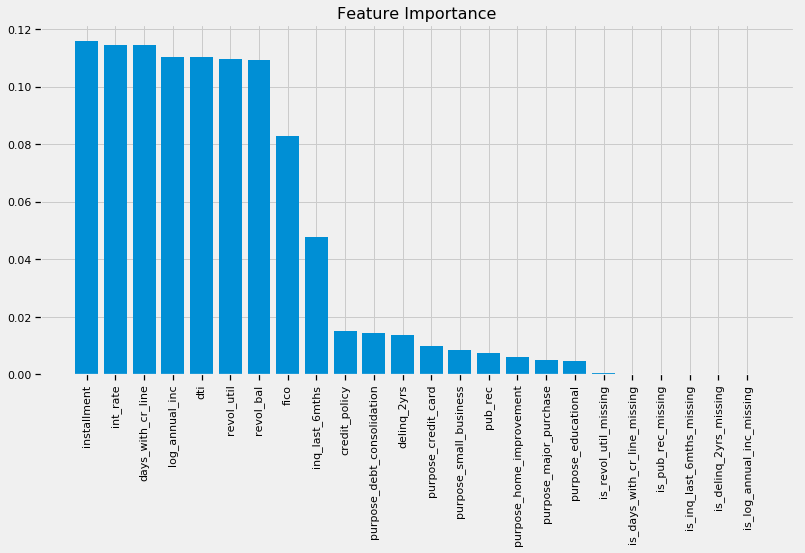

In [18]:
# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(Imputer(strategy="median").fit_transform(X_train)), y_train)

# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 25), importances[indices], align="center")
plt.xticks(range(1, 25), df.columns[df.columns != "not_fully_paid"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

Guided by the 10-fold cross validation *AUC* scores, it looks like all strategies have comparable results and missing values were generated randomly. Also, the added six binary features showed no importance when plotting feature importances from *Random Forest* classifier. Therefore, it's safe to drop those features and use *Median Imputation* method as a transformer later on in the pipeline.

In [19]:
# Drop generated binary features
X_train = X_train[:, :-6]
X_test = X_test[:, :-6]

 <h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Strategies to deal with imbalanced data</h3><br>
Classification problems in most real world applications have imbalanced data sets. In other words, the positive examples (minority class) are a lot less than negative examples (majority class). We can see that in spam detection, ads click, loan approvals, etc. In our example, the positive examples (people who haven't fully paid) were only 19% from the total examples. Therefore, accuracy is no longer a good measure of performance for different models because if we simply predict all examples to belong to the negative class, we achieve 81% accuracy. Better metrics for imbalanced data sets are *AUC* (area under the ROC curve) and f1-score. However, that's not enough because class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. As a result, we'll explore different methods to overcome class imbalance problem.
- Under-Sample: Under-sample the majority class with or w/o replacement by making the number of positive and negative examples equal. One of the drawbacks of under-sampling is that it ignores a good portion of training data that has valuable information. In our example, it would loose around 6500 examples. However, it's very fast to train.
- Over-Sample: Over-sample the minority class with or w/o replacement by making the number of positive and negative examples equal. We'll add around 6500 samples from the training data set with this strategy. It's a lot more computationally expensive than under-sampling. Also, it's more prune to overfitting due to repeated examples.
- EasyEnsemble: Sample several subsets from the majority class, build a classifier on top of each sampled data, and combine the output of all classifiers. More details can be found [here](http://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tsmcb09.pdf).
- Synthetic Minority Oversampling Technique (SMOTE): It over-samples the minority class but using synthesized examples. It operates on feature space not the data space. Here how it works:
    - Compute the k-nearest neighbors for all minority samples.
    - Randomly choose number between 1-k.
    - For each feature:
        - Compute the difference between minority sample and its randomly chosen neighbor (from previous step).
        - Multiply the difference by random number between 0 and 1.
        - Add the obtained feature to the synthesized sample attributes.
    - Repeat the above until we get the number of synthesized samples needed. More information can be found [here](https://www.jair.org/media/953/live-953-2037-jair.pdf).

There are other methods such as `EditedNearestNeighbors` and `CondensedNearestNeighbors` that we will not cover in this notebook and are rarely used in practice.

In most applications, misclassifying the minority class (false negative) is a lot more expensive than misclassifying the majority class (false positive). In the context of lending, loosing money by lending to a risky borrower who is more likely to not fully pay the loan back is a lot more costly than missing the opportunity of lending to trust-worthy borrower (less risky). As a result, we can use `class_weight` that changes the weight of misclassifying positive example in the loss function. Also, we can use different cut-offs assign examples to classes. By default, 0.5 is the cut-off; however, we see more often in applications such as lending that the cut-off is less than 0.5. Note that changing the cut-off from the default 0.5 reduce the overall accuracy but may improve the accuracy of predicting positive/negative examples.

We'll evaluate all the above methods plus the original model without resampling as a baseline model using the same *Random Forest* classifier we used in the missing values section.

In [20]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="mean"),
                         RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOriginal model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mUnder-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOver-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mEasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mSMOTE model's average AUC: {scores.mean():.3f}")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

Original model's average AUC: 0.652


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

Under-sampled model's average AUC: 0.640


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

Over-sampled model's average AUC: 0.650


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

EasyEnsemble model's average AUC: 0.665


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecat

SMOTE model's average AUC: 0.640


EasyEnsemble method has the highest 10-folds CV with average AUC = 0.665.

 <h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Build Ensemble methods</h3><br>
We'll build ensemble models using three different models as base learners:
- Extra Gradient Boosting
- Support Vector Classifier
- Random Forest

The ensemble models will be built using two different methods:
- Blending (average) ensemble model. Fits the base learners to the training data and then, at test time, average the predictions generated by all the base learners.
    - Use VotingClassifier from sklearn that:
        - fit all the base learners on the training data
        - at test time, use all base learners to predict test data and then take the average of all predictions.
- Stacked ensemble model: Fits the base learners to the training data. Next, use those trained base learners to generate predictions (meta-features) used by the meta-learner (assuming we have only one layer of base learners). There are few different ways of training stacked ensemble model:
    - Fitting the base learners to all training data and then generate predictions using the same training data it was used to fit those learners. This method is more prune to overfitting because the meta learner will give more weights to the base learner who memorized the training data better, i.e. meta-learner won't generate well and would overfit.
    - Split the training data into 2 to 3 different parts that will be used for training, validation, and generate predictions. It's a suboptimal method because held out sets usually have higher variance and different splits give different results as well as learning algorithms would have fewer data to train.
    - Use k-folds cross validation where we split the data into k-folds. We fit the base learners to the (k - 1) folds and use the fitted models to generate predictions of the held out fold. We repeat the process until we generate the predictions for all the k-folds. When done, refit the base learners to the full training data. This method is more reliable and will give models that memorize the data less weight. Therefore, it generalizes better on future data.

We'll use logistic regression as the meta-learner for the stacked model. Note that we can use k-folds cross validation to validate and tune the hyperparameters of the meta learner. We will not tune the hyperparameters of any of the base learners or the meta-learner; however, we will use some of the values recommended by the [Pennsylvania Benchmarking Paper](https://arxiv.org/pdf/1708.05070.pdf). Additionally, we won't use EasyEnsemble in training because, after some experimentation, it didn't improve the AUC of the ensemble model more than 2% on average and it was computationally very expensive. In practice, we sometimes are willing to give up small improvements if the model would become a lot more complex computationally. Therefore, we will use `RandomUnderSampler`. Also, we'll impute the missing values and standardize the data beforehand so that it would shorten the code of the ensemble models and allows use to avoid using `Pipeline`. Additionally, we will plot ROC and PR curves using test data and evaluate the performance of all models.

In [21]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


((2452, 18), (2452,))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning:

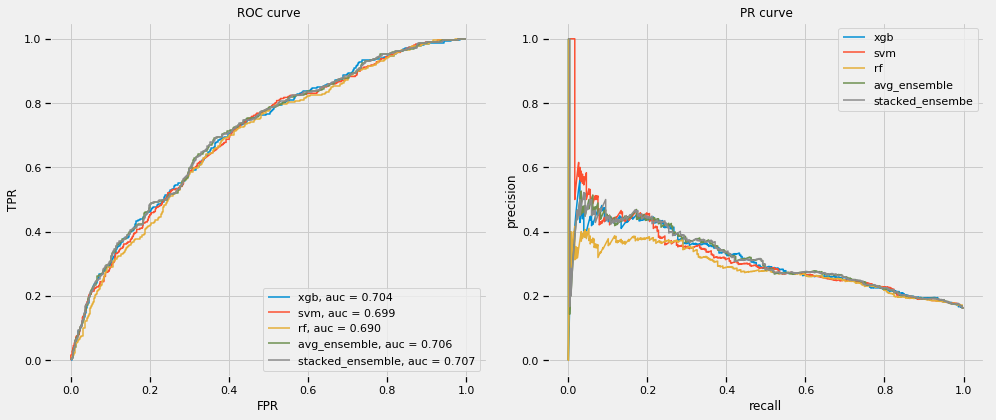

In [22]:
# Define base learners
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Refit the first stack on the full training set
first_stack.fit(X_res, y_res)
# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_res)

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

As we can see from the chart above, stacked ensemble model didn't improve the performance. One of the major reasons are that the base learners are considerably highly correlated especially *Random Forest* and *Gradient Boosting* (see the correlation matrix below).

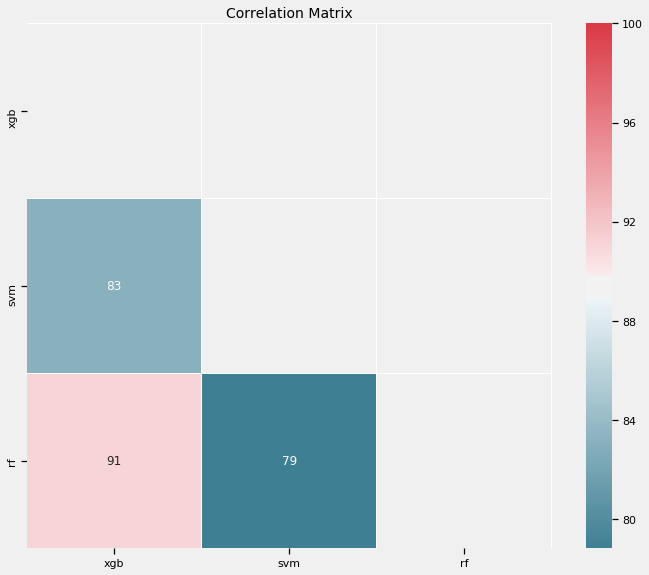

In [23]:
# Plot the correlation between base learners
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True);

In addition, with classification problems where False Negatives are a lot more expensive than False Positives, we may want to have a model with a high precision rather than high recall, i.e. the probability of the model to identify positive examples from randomly selected examples. Below is the confusion matrix:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


<Figure size 1152x576 with 0 Axes>

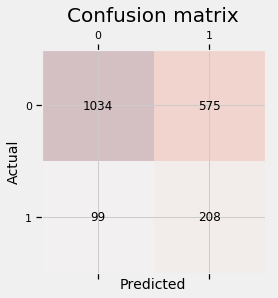

In [24]:
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test))
second_stack_preds = second_stack.predict(first_stack.transform(X_test))
conf_mat = confusion_matrix(y_test, second_stack_preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

Let's finally check the partial dependence plots to see what are the most important features and their relationships with whether the borrower will most likely pay the loan in full before mature data. we will plot only the top 8 features to make it easier to read.

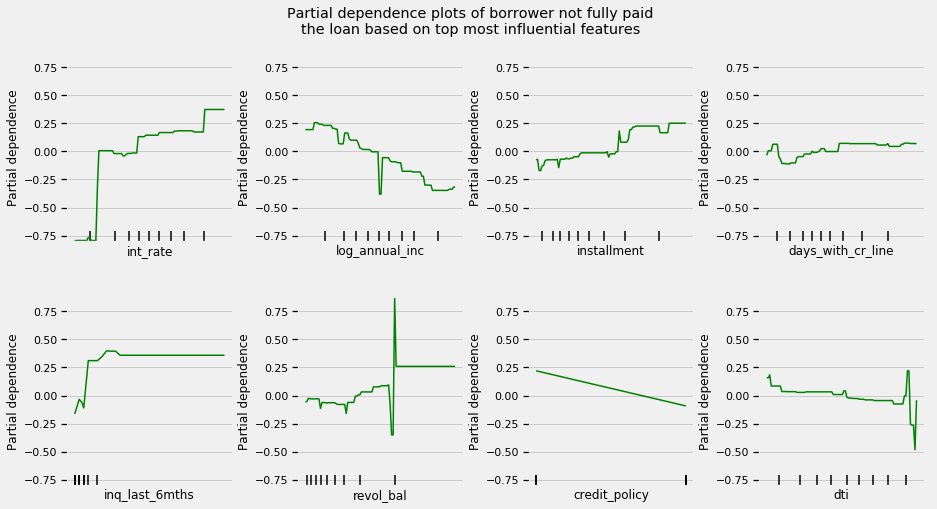

In [25]:
# Plot partial dependence plots
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_res, y_res)
fig, axes = plot_partial_dependence(gbrt, X_res,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=df.columns[:-6],
                                    figsize=(14, 8))
plt.subplots_adjust(top=0.9)
plt.suptitle("Partial dependence plots of borrower not fully paid\n"
             "the loan based on top most influential features")
for ax in axes: ax.set_xticks(())
for ax in [axes[0], axes[4]]: ax.set_ylabel("Partial dependence")

As we might expected, borrowers with lower annual income and less FICO scores are less likely to pay the loan fully; however, borrowers with lower interest rates (riskier) and smaller installments are more likely to pay the loan fully.

 <h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion</h2><br>
Most classification problems in the real world are imbalanced. Also, almost always data sets have missing values. In this notebook, we covered strategies to deal with both missing values and imbalanced data sets. We also explored different ways of building ensembles in sklearn. Below are some takeaway points:
- There is no definitive guide of which algorithms to use given any situation. What may work on some data sets may not necessarily work on others. Therefore, always evaluate methods using cross validation to get a reliable estimates.
- Sometimes we may be willing to give up some improvement to the model if that would increase the complexity much more than the percentage change in the improvement to the evaluation metrics.
- In some classification problems, *False Negatives* are a lot more expensive than *False Positives*. Therefore, we can reduce cut-off points to reduce the False Negatives.
- When building ensemble models, try to use good models that are as different as possible to reduce correlation between the base learners. We could've enhanced our stacked ensemble model by adding *Dense Neural Network* and some other kind of base learners as well as adding more layers to the stacked model.
- EasyEnsemble usually performs better than any other resampling methods.
- Missing values sometimes add more information to the model than we might expect. One way of capturing it is to add binary features for each feature that has missing values to check if each example is missing or not.